In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

from sberav.splits.tests import ClassifierTwoSampleTestBootstrap, KolmogorovSmirnovTwoSamplesTest

import json
from itertools import chain

sns.set_style('darkgrid')

In [7]:
def loader(path):
    with open(path, 'r') as f:
        for line in f.readlines():
            yield json.loads(line)

# Предобработка датасета

## Объединение json в датафрейм

In [20]:
data_path = "../../data/preprocessed/x5-uplift-features/"
dataset_list = list(chain(*[list(loader(data_path + f"0{i}.jsons.splitted")) for i in range(8)]))
df = pd.DataFrame.from_records(dataset_list)
print("Размер датасета:", df.shape)
df.to_csv(data_path + "features.csv", index=False)

Размер датасета: (80571, 23)


In [21]:
df.head()

,age,gender,client_id,epr_mean,epr_std,epr_median,epr_skew,eps_mean,eps_std,eps_median,eps_skew,rpr_mean,rpr_std,rpr_median,rpr_skew,rps_mean,rps_std,rps_median,rps_skew,sum_mean,sum_std,sum_median,sum_skew
0,34,U,0000bcec9c,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.963830,2.939636,1.00,2.642217,0.000000,0.000000,0.0,0.000000,299.845745,311.687287,210.780,2.414890
1,56,F,0000f0ecdb,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,9.083333,11.847562,4.85,1.539629,-16.500000,36.895122,0.0,-1.788854,1020.406667,1289.911974,542.185,1.626173
2,33,F,0001f552b0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,6.158333,10.634336,1.60,2.547242,0.000000,0.000000,0.0,0.000000,427.193333,307.178208,335.120,0.659669
3,73,U,00020e7b18,0.0,0.0,0.0,0.0,-1.176471,3.221897,0.0,-2.373464,16.823529,12.870556,15.50,0.802523,-31.411765,111.079229,0.0,-3.702573,1513.565294,951.441670,1374.500,1.110618
4,31,F,00034f1549,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,13.936364,17.702453,6.80,2.077230,0.000000,0.000000,0.0,0.000000,1302.468182,1103.774479,732.000,0.964627


## Добавление целевых колонок

In [25]:
df_train = pd.read_csv("../../data/datasets/x5-retail-hero/uplift_train.csv.gz", index_col="client_id")
df_train.head()

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1


In [30]:
df_train_client_ids = set(df_train.index.tolist())
df_client_ids = set(df.client_id.tolist())

(df_client_ids.intersection(df_train_client_ids))

40658

In [34]:
df_merged = df.set_index("client_id").join(df_train, how="left").dropna()
df_merged

,age,gender,epr_mean,epr_std,epr_median,epr_skew,eps_mean,eps_std,eps_median,eps_skew,rpr_mean,rpr_std,rpr_median,rpr_skew,rps_mean,rps_std,rps_median,rps_skew,sum_mean,sum_std,sum_median,sum_skew,treatment_flg,target
client_id,,,,,,,,,,,,,,,,,,,,,,,,
0001f552b0,33,F,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,6.158333,10.634336,1.60,2.547242,0.000000,0.000000,0.0,0.000000,427.193333,307.178208,335.120,0.659669,1.0,1.0
00020e7b18,73,U,0.0,0.0,0.0,0.0,-1.176471,3.221897,0.0,-2.373464,16.823529,12.870556,15.50,0.802523,-31.411765,111.079229,0.0,-3.702573,1513.565294,951.441670,1374.500,1.110618,1.0,1.0
0004231e2a,56,F,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,4.000000,3.452535,1.85,0.465942,0.000000,0.000000,0.0,0.000000,477.916667,292.505116,381.000,0.390853,1.0,0.0
0008b2cb41,25,U,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,8.088889,9.269717,1.80,0.772569,0.000000,0.000000,0.0,0.000000,524.934444,648.084106,328.070,1.807648,1.0,1.0
0018650c30,35,U,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,5.083784,5.170891,3.10,2.021097,-6.378378,34.638169,0.0,-5.733762,525.112973,326.249867,585.000,0.348691,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381ffd590b,31,M,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,10.695238,7.097181,10.90,0.482618,-11.047619,23.509828,0.0,-1.773429,1247.857143,710.032298,1228.870,0.620327,0.0,1.0
382006deb4,53,U,0.0,0.0,0.0,0.0,-0.526316,2.232969,0.0,-4.006938,5.321053,5.863498,2.60,1.443846,-4.263158,10.274353,0.0,-2.238413,503.995263,385.419511,417.910,1.362780,0.0,1.0
3824a10246,31,M,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,14.570588,16.694936,6.30,1.526712,0.000000,0.000000,0.0,0.000000,886.350000,574.790762,608.000,0.421705,1.0,1.0


In [36]:
df_merged.treatment_flg.value_counts()

0.0    19996
1.0    19879
Name: treatment_flg, dtype: int64

/home/isabella/code/study/diploma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

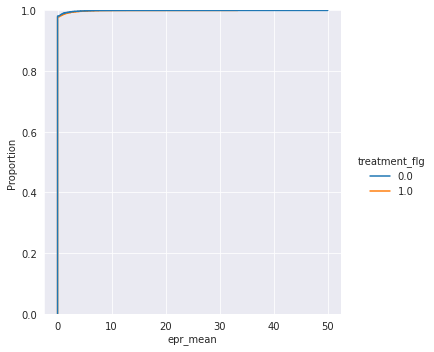

<Figure size 432x288 with 0 Axes>

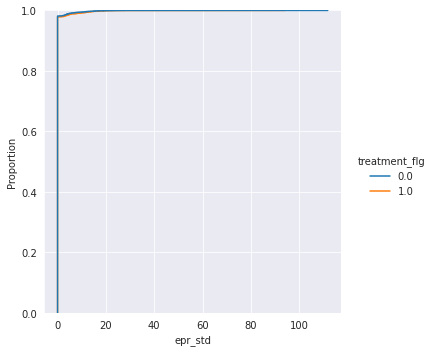

<Figure size 432x288 with 0 Axes>

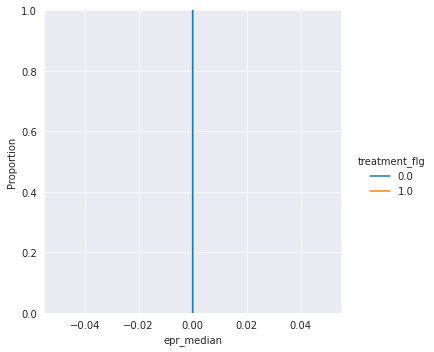

<Figure size 432x288 with 0 Axes>

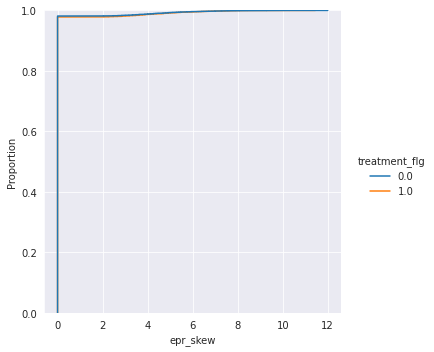

<Figure size 432x288 with 0 Axes>

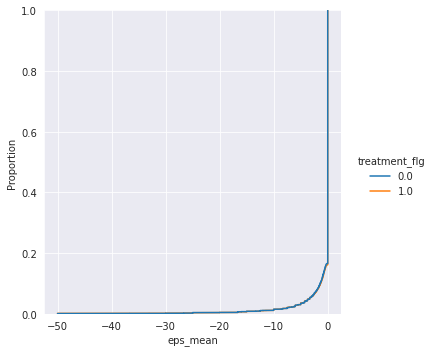

<Figure size 432x288 with 0 Axes>

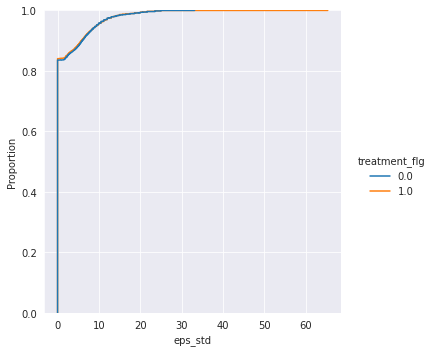

<Figure size 432x288 with 0 Axes>

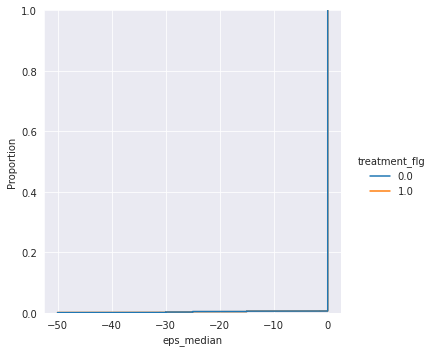

<Figure size 432x288 with 0 Axes>

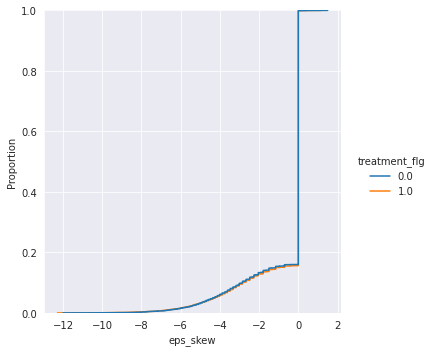

<Figure size 432x288 with 0 Axes>

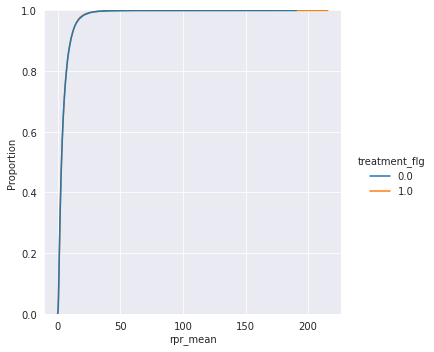

<Figure size 432x288 with 0 Axes>

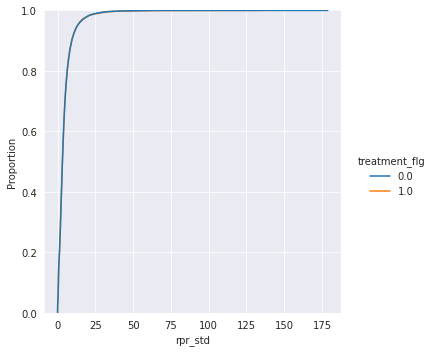

<Figure size 432x288 with 0 Axes>

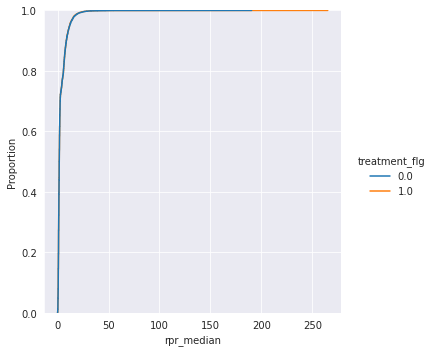

<Figure size 432x288 with 0 Axes>

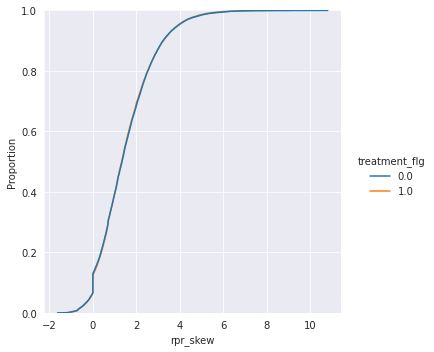

<Figure size 432x288 with 0 Axes>

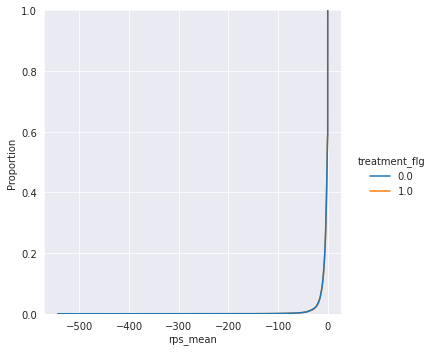

<Figure size 432x288 with 0 Axes>

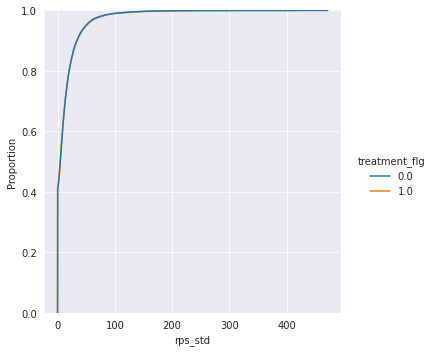

<Figure size 432x288 with 0 Axes>

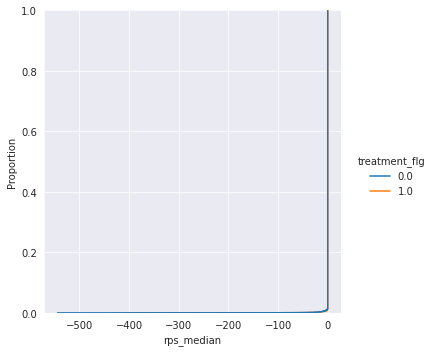

<Figure size 432x288 with 0 Axes>

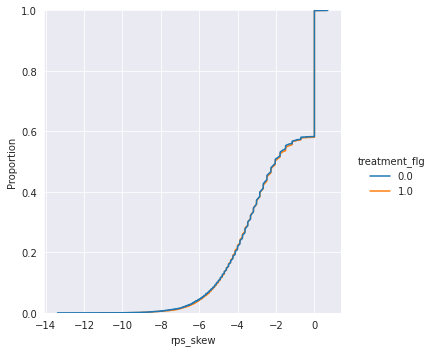

<Figure size 432x288 with 0 Axes>

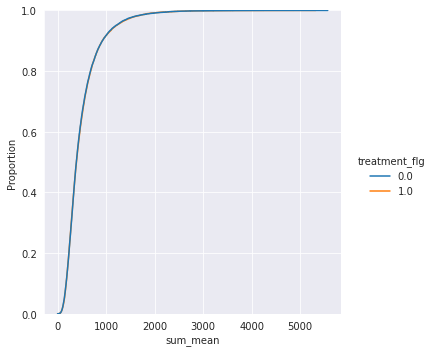

<Figure size 432x288 with 0 Axes>

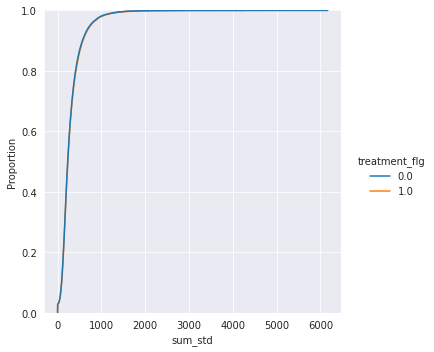

<Figure size 432x288 with 0 Axes>

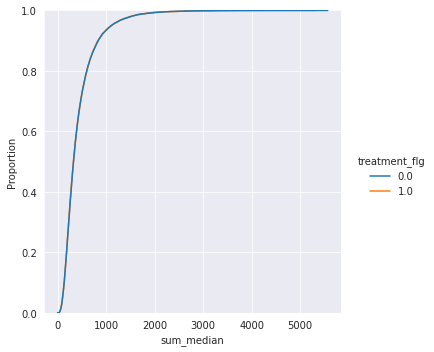

<Figure size 432x288 with 0 Axes>

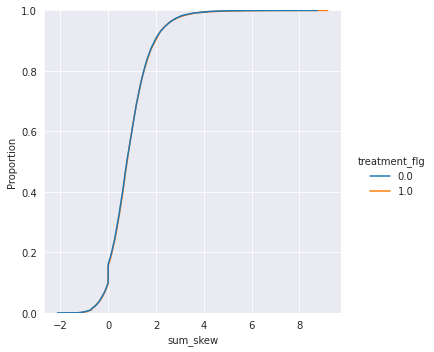

In [40]:
for col in df_merged.columns:
    if col in ['treatment_flg', 'target', 'age', 'gender']: continue
    plt.figure()
    sns.displot(x=df_merged[col], kind='ecdf', hue=df_merged.treatment_flg)

# Тестирование признаков

## Тест Колмогорова-Смирнова

In [49]:
control = df_merged[df_merged.treatment_flg == 0]
target = df_merged[df_merged.treatment_flg == 1]
    
for col in df_merged.columns:
    if col in ['treatment_flg', 'target', 'age', 'gender']: continue
    test = KolmogorovSmirnovTwoSamplesTest(
        columns = [col, ],
        significance_level=0.05, 
        verbose=0,
    )
    print(test.validate(control[col], target[col]))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


## Classifier 2 sample test

In [51]:
test = ClassifierTwoSampleTestBootstrap(significance_level=0.05, 
                                        bootstraps=10_000, 
                                        verbose=1, 
                                        n_jobs=1, 
                                        threads=-1)
columns = df_merged.columns.difference(['treatment_flg', 'target', 'age', 'gender'])
test.validate(control[columns], target[columns])

2021-04-04 09:55:48,846: sberav.base.handler.c2st - INFO: Bootstrapping 10000 samples
100%|██████████| 100/100 [41:53<00:00, 25.14s/it]
2021-04-04 10:37:42,733: sberav.base.handler.c2st - INFO: C2ST test results: p-value - 0.1843
2021-04-04 10:37:42,738: sberav.base.handler.c2st - INFO: H0 cannot be rejected: there is no evidence that samples drawn from different distributions


[]

<AxesSubplot:title={'center':'Classifier Two Sample Test'}, xlabel='hamming loss'>

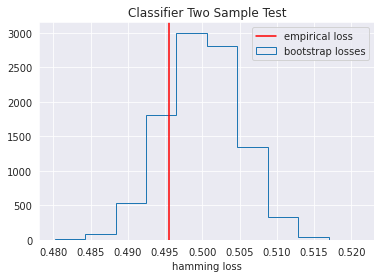

In [52]:
fig, ax = plt.subplots()
test.plot_distributions(ax)

In [54]:
df_merged.to_csv(data_path + "features_with_target.csv")